In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../Code/')
import adaprobe
import time
import seaborn as sns
from scipy.sparse import csc_matrix
from sklearn.linear_model import Lasso
import imageio as io
from adaprobe.optimise.cavi_online_spike_and_slab import _sample_phi_independent_truncated_normals
from scipy.stats import norm
from importlib import reload
from functools import partial


Bad key "text.kerning_factor" on line 4 in
C:\Users\Marcus\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
from numba import njit, vectorize, float64, prange

In [3]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [4]:
fontsize = 12

In [5]:
dat = np.load('../Data/npy/201118_cell1_A.npy', allow_pickle=True).item()
img = io.imread('../Data/tiff/201118_cell1_merge2.tif')

In [6]:
cell_locs = dat['cell_locs']
order = dat['stim_order']
stimuli = dat['stimuli']
targets = dat['targets']
responses = dat['responses']

L = stimuli[:, :3]
I = stimuli[:, -1]

y = np.trapz(responses, axis=1)

In [7]:
spacing = 10
minx, maxx = np.min(cell_locs[:, 0]), np.max(cell_locs[:, 0])
miny, maxy = np.min(cell_locs[:, 1]), np.max(cell_locs[:, 1])
xr = np.arange(minx - spacing, maxx + spacing)
yr = np.arange(miny - spacing, maxy + spacing)
xgrid, ygrid = np.meshgrid(xr, yr)
grid = np.c_[xgrid.flatten(), ygrid.flatten()]

depths = np.unique(L[:, -1])
ndepths = len(depths)
dim = 26

# Blind maps

In [8]:
def find_common(arrs):
    """Recursive algorithm for finding common elements in a list of arrays.
    """
    if len(arrs) == 1:
        return arrs[0]
    elif len(arrs) == 2:
        return np.intersect1d(arrs[0], arrs[1])
    else:
        return np.intersect1d(arrs[0], find_common(arrs[1:]))

def find_reference(loc, reference, secondary=None):
    common = find_common([np.where(loc[i] == reference[:, i])[0] for i in range(len(loc))])
    if secondary is None:
        return common
    else:
        return np.intersect1d(common, secondary)
    
def find_stim_id(loc):
    return find_reference(loc, targets)

def lasso_map(power):
    trial_locs = np.where(I == power)[0]
    cols = np.array([find_stim_id(L[trial_locs[i]]) for i in range(len(trial_locs))]).squeeze()
    rows = np.array(range(len(cols)))
    sparse_data = np.ones(len(cols))
    A = csc_matrix((sparse_data, (rows, cols)))
    
    alpha = 1e-4
    sparse_lasso = Lasso(alpha=alpha, fit_intercept=False, max_iter=1000)
    sparse_lasso.fit(A, y[trial_locs])
    
    return sparse_lasso.coef_
    

In [9]:
lmap_50 = lasso_map(50)
lmap_70 = lasso_map(70)

In [10]:
xs, ys, depths = np.unique(targets[:, 0]), np.unique(targets[:, 1]), np.unique(targets[:, -1])

In [11]:
fcoef = 3.5
depths = np.unique(targets[:, -1])
ndepths = len(depths)
dim = 26

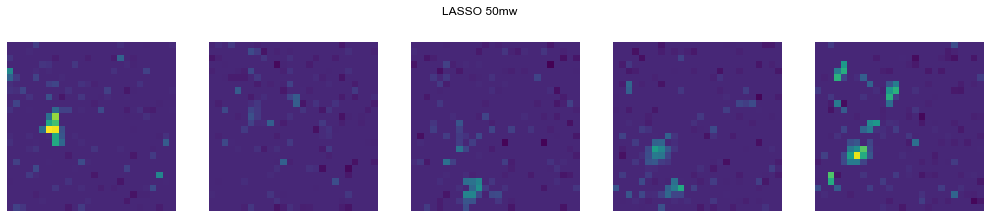

In [12]:
plt.figure(figsize=(fcoef*ndepths, fcoef))
plt.suptitle('LASSO 50mw')
vmin = np.min(lmap_50)
vmax = np.max(lmap_50)
for i, d in enumerate(depths):
    curr_plane = np.where(targets[:, -1] == d)[0]
    plt.subplot(1, ndepths, i + 1)
    plt.imshow(lmap_50[curr_plane].reshape([dim, dim]).T, cmap='viridis_r', vmin=vmin, vmax=vmax)
    plt.axis('off')
plt.show()

In [13]:
np.where(I == 70)[0]

array([16900, 16901, 16902, ..., 50697, 50698, 50699], dtype=int64)

In [14]:
cell_locs_as_targets = np.array([find_stim_id(loc) for loc in cell_locs]).squeeze()
coms = targets[cell_locs_as_targets]

In [15]:
coms_on_plane = np.where(coms[:, -1] == d)[0]

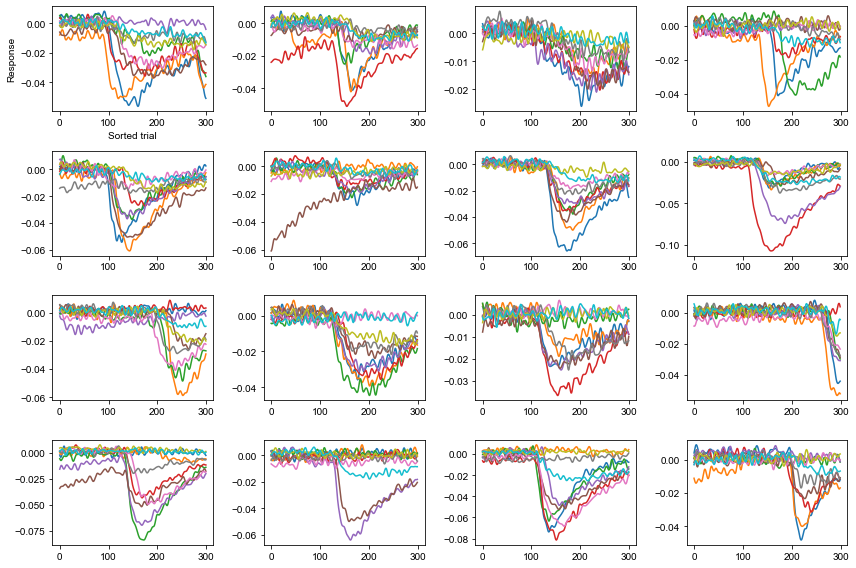

In [16]:
plt.figure(figsize=(12, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    pts = responses[find_reference(coms[i], L, secondary=np.where(I == 70)[0])]
    plt.plot(pts.T)
    if i == 0:
        plt.xlabel('Sorted trial')
        plt.ylabel('Response')
plt.tight_layout()
plt.show()

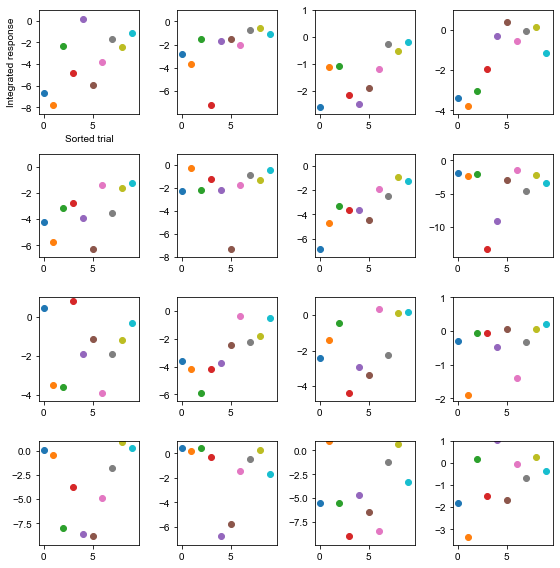

In [17]:
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    pts = y[find_reference(coms[i], L, secondary=np.where(I == 70)[0])]
    for indx, pt in enumerate(pts):
        plt.scatter(indx, pt)
    plt.ylim([1.1*np.min(pts), 1])
    if i == 0:
        plt.xlabel('Sorted trial')
        plt.ylabel('Integrated response')
plt.tight_layout()
plt.show()

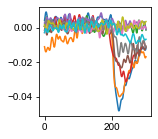

In [18]:
plt.figure(figsize=(2, 2))
plt.plot(responses[find_reference(coms[i], L, secondary=np.where(I == 70)[0])].T)
plt.show()

In [19]:
lasso_init = np.zeros(len(cell_locs))

In [20]:
dummy_arr = np.arange(26**2).reshape([26, 26])

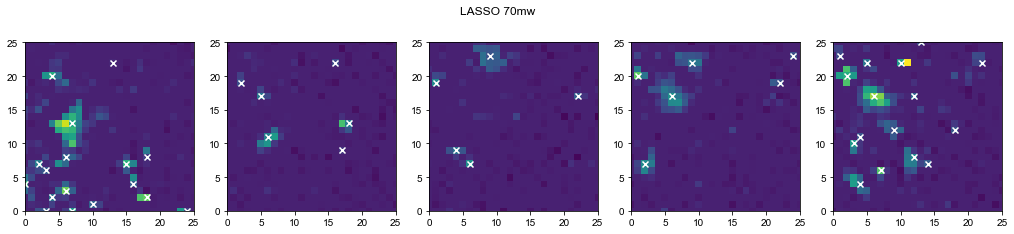

In [21]:
plt.figure(figsize=(fcoef*ndepths, fcoef))
plt.suptitle('LASSO 70mw')
vmin = np.min(lmap_70)
vmax = np.max(lmap_70)
for i, d in enumerate(depths):
    curr_plane = np.where(targets[:, -1] == d)[0]
    cell_loc_on_plane = []
    
    for j in range(len(cell_locs)):
        tmp = np.where(cell_locs_as_targets[j] == curr_plane)[0]
        if len(tmp) > 0:
            cell_loc_on_plane += [tmp]
            lasso_init[j] = lmap_70[curr_plane][tmp]
    cell_loc_on_plane = np.array(cell_loc_on_plane)
    coords = np.array([np.where(dummy_arr == cell_loc_on_plane[i]) for i in range(len(cell_loc_on_plane))]).squeeze()

    plt.subplot(1, ndepths, i + 1)
    plt.imshow(lmap_70[curr_plane].reshape([dim, dim]).T, cmap='viridis_r', vmin=vmin, vmax=vmax)
    plt.scatter(coords[:, 0], coords[:, 1], marker='x', color='w')
    plt.xlim([0, 25])
    plt.ylim([0, 25])
#     plt.axis('off')
# plt.savefig('figs/experimental_data/speckle_analysis/lasso_maps_70mw.png', format='png', bbox_inches='tight')
plt.show()

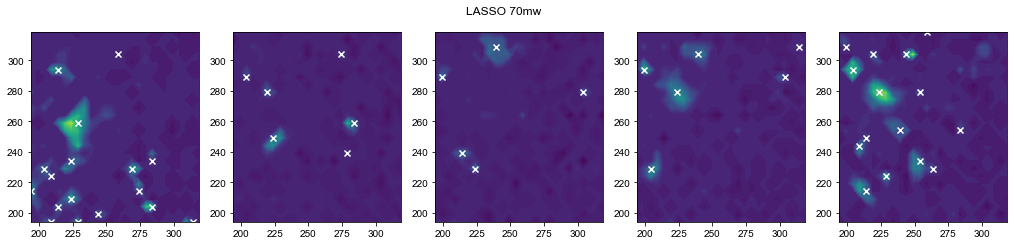

In [22]:
plt.figure(figsize=(fcoef*ndepths, fcoef))
plt.suptitle('LASSO 70mw')
vmin = np.min(lmap_70)
vmax = np.max(lmap_70)

for i, d in enumerate(depths):
    curr_plane = np.where(targets[:, -1] == d)[0]
    cell_locs_on_plane = np.where(cell_locs[: -1] == d)[0]
    plt.subplot(1, ndepths, i + 1)
    plt.contourf(xs, ys, lmap_70[curr_plane].reshape([dim, dim]).T, 50, cmap='viridis_r', vmin=vmin, vmax=vmax, origin='upper')
    plt.scatter(cell_locs[cell_locs_on_plane, 0], cell_locs[cell_locs_on_plane, 1], marker='x',color='white')
    plt.xlim([np.min(xs), np.max(xs)])
    plt.ylim([np.min(ys), np.max(ys)])
#     plt.axis('off')
# plt.savefig('figs/experimental_data/speckle_analysis/lasso_maps_70mw.png', format='png', bbox_inches='tight')
plt.show()

# Fit circuit model

In [23]:
def init_hist_dict(n_dicts=1, descriptors=[]):
    lsd = [{} for _ in range(n_dicts)]
    for d in lsd:
        for descr in descriptors:
            d[descr] = []
    if n_dicts == 1:
        return lsd[0]
    else:
        return lsd

def record_hist(d, model, umap=None, descriptors=[]):
    for descr in descriptors:
        d[descr] += [model.state[descr]]
        
descriptors = ['mu', 'beta', 'alpha', 'lam', 'phi_map', 'phi_cov', 'shape', 'rate']

In [30]:
N = len(cell_locs)

interp = 0.1

priors = {
    'alpha': 0.5 * np.ones(N),
    'omega': np.array([np.array([18.209957, 14.667394, 47.966736]) for _ in range(N)]),
    'mu': np.zeros(N),
    'beta': 2 * np.ones(N),
    'shape': 1,
    'rate': 1,
    'phi_map': np.c_[0.05319851 * np.ones(N), 5.5563254 * np.ones(N)],
    'phi_cov': np.array([np.array([[1e-2, 0], [0, 1e0]]) for _ in range(N)])
}

fit_options = {
    'iters': 10,
    'newton_steps': 15, # default 10
    'lam_update': 'monte-carlo',
    'num_mc_samples': 10, # default 5
    'verbose': False,
    'init_t': 1e1,
    't_loops': 3, # default 3
    't_mult': 15,
    'interp': interp
}

ensemble_size = 3
models = [adaprobe.Model(cell_locs, priors=priors, variational_model='laplace-3d') for _ in range(ensemble_size)]

In [31]:
K = len(y)
rand_ord = np.arange(K)
np.random.shuffle(rand_ord)

In [32]:
y_train = y[rand_ord]
I_train = I[rand_ord]
L_train = L[rand_ord]

In [34]:
hist = init_hist_dict(ensemble_size, descriptors=descriptors)

for i in range(ensemble_size):
    t1 = time.time()
    for k in range(K):
        print('trial %i/%i'%(k + 1, K), end='\r')
        models[i].update(y_train[k], (L_train[k], I_train[k]), fit_options=fit_options, method='cavi_online_spike_and_slab_3d_laplace')
        record_hist(hist[i], models[i], descriptors=descriptors)

    t2 = time.time()
    print('run %i: elapsed time %.2f'%(i, t2 - t1))

run 0: elapsed time 74.94
run 1: elapsed time 77.66
run 2: elapsed time 76.33


In [35]:
# # Plot synapse means

# plt.figure(figsize=(6, 2.5))
# plt.plot(np.array(hist['mu']))
# plt.xticks(np.arange(0, 2*K + 1, 1e4), fontsize=fontsize)
# plt.gca().set_xticklabels(np.arange(0, 11, 1))
# plt.plot([5e4, 5e4], [-6, 0], '--', color='gray')
# plt.title('Run %i'%(i+1), fontsize=fontsize)
# for loc in ['top', 'right']:
#     plt.gca().spines[loc].set_visible(False)
# if i == 0:
#     plt.ylabel('Synapse posterior mean', fontsize=fontsize)
#     plt.xlabel('Trial (x10,000)', fontsize=fontsize)
#     plt.yticks(np.arange(-6, 2, 2), fontsize=fontsize)
# else:
#     plt.yticks([])
# plt.show()

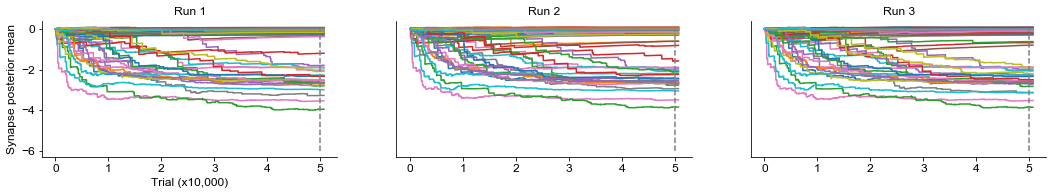

In [36]:
## Ensemble code

# Plot synapse means

plt.figure(figsize=(ensemble_size*6, 2.5))
for i in range(ensemble_size):
    plt.subplot(1, ensemble_size, i + 1)
    plt.plot(np.array(hist[i]['mu']))
#     plt.xlim([0, K])
    plt.xticks(np.arange(0, 2*K + 1, 1e4), fontsize=fontsize)
    plt.gca().set_xticklabels(np.arange(0, 11, 1))
    plt.plot([5e4, 5e4], [-6, 0], '--', color='gray')
    plt.title('Run %i'%(i+1), fontsize=fontsize)
    for loc in ['top', 'right']:
        plt.gca().spines[loc].set_visible(False)
    if i == 0:
        plt.ylabel('Synapse posterior mean', fontsize=fontsize)
        plt.xlabel('Trial (x10,000)', fontsize=fontsize)
        plt.yticks(np.arange(-6, 2, 2), fontsize=fontsize)
    else:
        plt.yticks([])
plt.show()

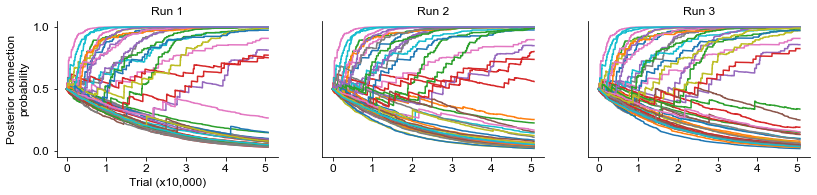

In [37]:
## Ensemble code
# Plot connection probs

plt.figure(figsize=(ensemble_size*4.5, 2.5))
for i in range(ensemble_size):
    plt.subplot(1, ensemble_size, i + 1)
    plt.plot(np.array(hist[i]['alpha']))
#     plt.xlim([0, K])
    plt.ylim([-0.05, 1.05])
    plt.xticks(np.arange(0, K+1, 1e4), fontsize=fontsize)
    plt.gca().set_xticklabels(np.arange(0, 11, 1))
    plt.title('Run %i'%(i+1), fontsize=fontsize)
    for loc in ['top', 'right']:
        plt.gca().spines[loc].set_visible(False)
    if i == 0:
        plt.ylabel('Posterior connection\nprobability', fontsize=fontsize)
        plt.xlabel('Trial (x10,000)', fontsize=fontsize)
        plt.yticks([0, 0.5, 1], fontsize=fontsize)
    else:
        plt.yticks([])
plt.show()

In [38]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [ ]:
# # for j in range(ensemble_size):
# for j in [1]:
#     cntr = 1
#     power = 70
#     model = models[j]
#     phi = model.state['phi_map']
#     cov = model.state['phi_cov']
#     phi_0_lower = [phi[i, 0] - np.sqrt(cov[i][0, 0]) for i in range(N)]
#     phi_0_upper = [phi[i, 0] + np.sqrt(cov[i][0, 0]) for i in range(N)]
#     phi_1_lower = [phi[i, 1] - np.sqrt(cov[i][1, 1]) for i in range(N)]
#     phi_1_upper = [phi[i, 1] + np.sqrt(cov[i][1, 1]) for i in range(N)]
#     omega = model.state['omega']
    
#     plt.figure(figsize=(10, 18))
#     for i in range(N):
#         # Set up receptive fields
#         xran = np.arange(0, 50, 0.01)
#         fn = sigmoid(phi[i, 0] * power * np.exp(-omega[i] * xran) - phi[i, 1])
#         fn_lower = sigmoid(phi_0_lower[i] * power * np.exp(-omega[i] * xran) - phi_1_lower[i])
#         fn_upper = sigmoid(phi_0_upper[i] * power * np.exp(-omega[i] * xran) - phi_1_upper[i])
        
#         # Make plot
#         plt.subplot(10, 5, cntr)
#         plt.plot(xran, fn, 'k')
#         plt.fill_between(xran, fn_lower, fn_upper, alpha=0.35, facecolor='firebrick', edgecolor='None')
#         plt.ylim([-0.5e-1, 1 + 0.5e-1])
#         plt.xticks([0, 25, 50])
#         if cntr == 1:
#             plt.ylabel('Spike\nprobability', fontsize=fontsize)
#             plt.xlabel('Distance from\ncentroid ($\mu$m)', fontsize=fontsize)
#         cntr += 1
#     plt.tight_layout()
#     plt.show()

In [68]:
@njit
def _get_mk_3d_omega(Omega, C, N, Ik, Lk):
    mk = np.zeros(N)
    for n in prange(N):
        mk[n] = Ik * np.exp(-(Lk - C[n]) @ Omega[n] @ (Lk - C[n]))
    return mk

def get_m_3d_omega(I, L, K, N, get_mk):
    m = np.zeros((N, K))
    for k in range(K):
        m[:, k] = get_mk(I[k], L[k])
    return m

def model_evidence_omega_3d(y, model, I, L, num_mc_samples=5):
    K = len(y)
    N = model.n_presynaptic
    get_mk_3d_omega = partial(_get_mk_3d_omega, model.state['Omega'], model.cell_locs, N)
    m = get_m_3d_omega(I, L, K, N, get_mk_3d_omega)
    phi = np.array([_sample_phi_independent_truncated_normals(
            model.state['phi_map'][n], model.state['phi_cov'][n], num_mc_samples=num_mc_samples
        ) for n in range(N)])
    f = np.zeros((num_mc_samples, N, K))
    s = np.zeros_like(f)
    w = np.zeros((num_mc_samples, N))
    sig = np.zeros(num_mc_samples)
    llh = np.zeros(num_mc_samples)
    for i in range(num_mc_samples):
        f[i] = sigmoid(np.array([phi[n, i, 0] * m[n] - phi[n, i, 1] for n in range(N)]))
        s[i] = np.random.rand(N, K) <= f[i]
        w[i] = (np.random.rand(N) <= model.state['alpha']) * np.random.normal(model.state['mu'], model.state['beta'])
        sig[i] = np.sqrt(1/np.random.gamma(model.state['shape'], 1/model.state['rate']))
        llh[i] = np.sum(norm.pdf(y, w[i] @ s[i], sig[i]))
    return np.mean(llh)

def model_evidence_3d_laplace(y, model, I, L, num_mc_samples=5):
    N = model.n_presynaptic
    K = len(I)
    m = np.zeros((N, K))
    for n in range(N):
        m[n] = I * np.exp(-np.sum(np.abs(L - model.cell_locs[n])/model.state['omega'][n], 1))
    phi = np.array([_sample_phi_independent_truncated_normals(
        model.state['phi_map'][n], model.state['phi_cov'][n], num_mc_samples=num_mc_samples
    ) for n in range(N)])
    f = np.zeros((num_mc_samples, N, K))
    s = np.zeros_like(f)
    w = np.zeros((num_mc_samples, N))
    sig = np.zeros(num_mc_samples)
    llh = np.zeros(num_mc_samples)
    for i in range(num_mc_samples):
        f[i] = sigmoid(np.array([phi[n, i, 0] * m[n] - phi[n, i, 1] for n in range(N)]))
        s[i] = np.random.rand(N, K) <= f[i]
        w[i] = (np.random.rand(N) <= model.state['alpha']) * np.random.normal(model.state['mu'], model.state['beta'])
        sig[i] = np.sqrt(1/np.random.gamma(model.state['shape'], 1/model.state['rate']))
        llh[i] = np.sum(norm.pdf(y, w[i] @ s[i], sig[i]))
    return np.mean(llh)

In [69]:
ev = np.array([model_evidence_3d_laplace(y, model, I, L, num_mc_samples=10) for model in models])
posterior_weights = ev/np.sum(ev)

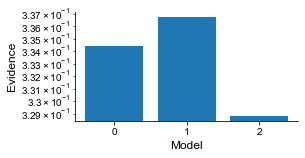

In [70]:
plt.figure(figsize=(4, 2))
plt.bar(np.arange(ensemble_size), posterior_weights)
plt.xticks(np.arange(ensemble_size))
for loc in ['top', 'right']:
    plt.gca().spines[loc].set_visible(False)
plt.xlabel('Model', fontsize=fontsize)
plt.ylabel('Evidence', fontsize=fontsize)
plt.yscale('log')
plt.show()

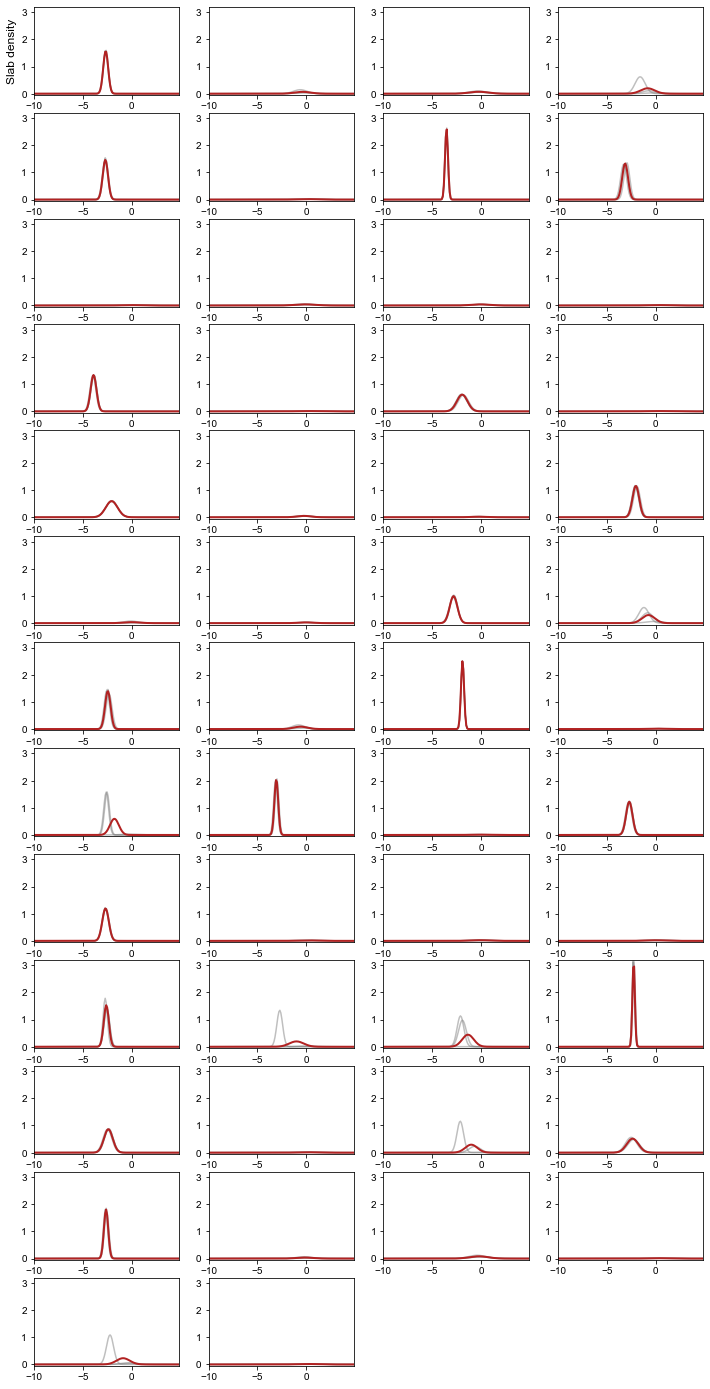

In [71]:
xrange = np.arange(-10, 5, 0.1)
def gaussf(mean, sdev):
    return 1/(np.sqrt(2 * np.pi * sdev**2)) * np.exp(-1/(2 * sdev**2) * (xrange - mean)**2)

alpha = np.sum([models[i].state['alpha'] * posterior_weights[i] for i in range(len(posterior_weights))], 0)
mu = np.sum([models[i].state['mu'] * posterior_weights[i] for i in range(len(posterior_weights))], 0)
beta = np.sum([models[i].state['beta'] * posterior_weights[i] for i in range(len(posterior_weights))], 0)
posteriors = np.array([alpha[n] * gaussf(mu[n], beta[n]) for n in range(N)])

ymax = np.max(np.array([gaussf(models[i].state['mu'][n], models[i].state['beta'][n]) for i in range(ensemble_size) for n in range(N)]))

plt.figure(figsize=(12, 2*(N/4)))
for n in range(N):
    plt.subplot(int(np.ceil(N/4)), 4, n + 1)
    
    # Plot posteriors
    for i in range(ensemble_size):
        postn = models[i].state['alpha'][n] * gaussf(models[i].state['mu'][n], models[i].state['beta'][n])
        plt.plot(xrange, postn, color='gray', alpha=0.5)
    plt.plot(xrange, posteriors[n], color='firebrick', linewidth=2)
    
    plt.ylim([-0.05, ymax + 0.05])
    plt.xlim(np.min(xrange), np.max(xrange))
    if n == 0: 
        plt.ylabel('Slab density', fontsize=fontsize)
plt.show()

## 50mW maps

In [81]:
pred_maps_50 = {}
pred_maps_70 = {}
for d in depths:
    print('Depth', d)
    pred_maps_50[str(d)] = [
        adaprobe.experimental_design.posterior_predictive_map_on_plane_3d_laplace(grid, d, 50, models[i], n_samples=10) for i in range(ensemble_size)
    ]
    pred_maps_70[str(d)] = [
        adaprobe.experimental_design.posterior_predictive_map_on_plane_3d_laplace(grid, d, 70, models[i], n_samples=10) for i in range(ensemble_size)
    ]

Depth -75.0
Depth -50.0
Depth -25.0
Depth 0.0
Depth 25.0


In [89]:
reload(adaprobe.experimental_design)

<module 'adaprobe.experimental_design' from '../Code\\adaprobe\\experimental_design.py'>

In [90]:
pred_map_50_bayes = {}
pred_map_70_bayes = {}
for d in depths:
    print('Depth', d)
    pred_map_50_bayes[str(d)] = adaprobe.experimental_design.posterior_predictive_map_on_plane_bayes_ensemble_3d_laplace(
        grid, y, plane=d, power=50, I_hist=I, L_hist=L, models=models, n_samples=20)
    pred_map_70_bayes[str(d)] = adaprobe.experimental_design.posterior_predictive_map_on_plane_bayes_ensemble_3d_laplace(
        grid, y, plane=d, power=70, I_hist=I, L_hist=L, models=models, n_samples=20)

Depth -75.0
Depth -50.0
Depth -25.0
Depth 0.0
Depth 25.0


In [ ]:
# vmax = np.max(np.array([pred_map for pred_map in pred_maps_70.values()]))
# vmin = np.min(np.array([pred_map for pred_map in pred_maps_70.values()]))

In [91]:
fcoef = 3

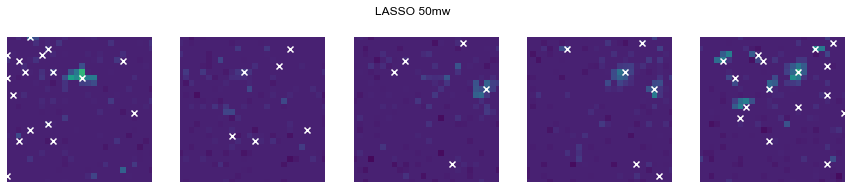

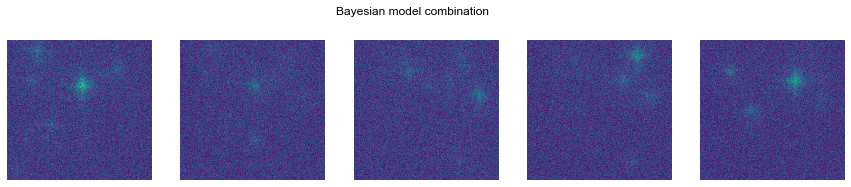

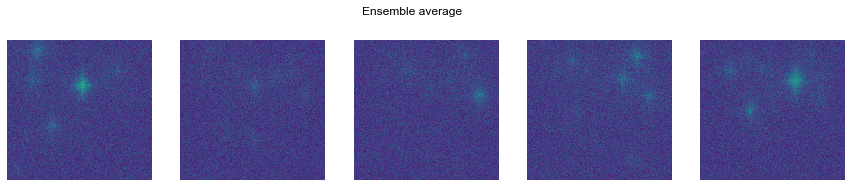

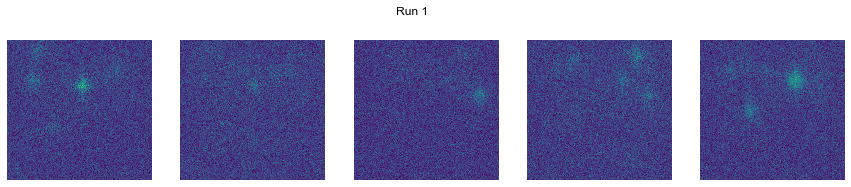

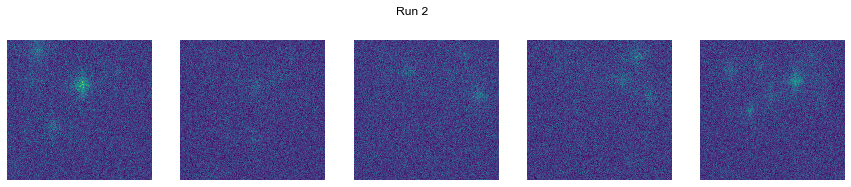

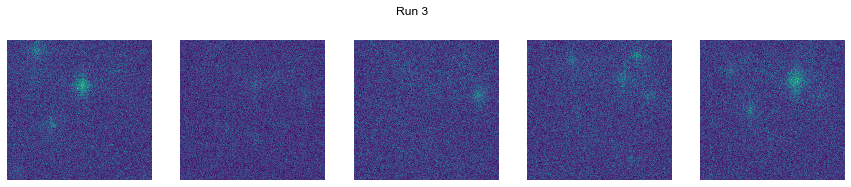

In [92]:
# Lasso maps
plt.figure(figsize=(fcoef*ndepths, fcoef))
plt.suptitle('LASSO 50mw')
for i, d in enumerate(depths):
    curr_plane = np.where(targets[:, -1] == d)[0]
    cell_loc_on_plane = []
    for j in range(len(cell_locs)):
        tmp = np.where(cell_locs_as_targets[j] == curr_plane)[0]
        if len(tmp) > 0:
            cell_loc_on_plane += [tmp]
            lasso_init[j] = lmap_70[curr_plane][tmp]
    cell_loc_on_plane = np.array(cell_loc_on_plane)
    coords = np.array([np.where(dummy_arr == cell_loc_on_plane[i]) for i in range(len(cell_loc_on_plane))]).squeeze()
    plt.subplot(1, ndepths, i + 1)
    plt.imshow(lmap_50[curr_plane].reshape([dim, dim]), cmap='viridis_r', vmin=vmin, vmax=vmax)
    plt.scatter(coords[:, 1], coords[:, 0], color='w', marker='x')
    plt.xlim([0, dim-1])
    plt.ylim([dim-1, 0])
    plt.axis('off')
# plt.savefig('figs/experimental_data/posterior_predictive_mean_lasso_50mw.png', format='png', dpi=200, bbox_inches='tight')
plt.show()

plt.figure(figsize=(fcoef*ndepths, fcoef))
plt.suptitle('Bayesian model combination')
for i, d in enumerate(depths):
    plt.subplot(1, ndepths, i + 1)
    plt.imshow(pred_map_50_bayes[str(d)].reshape(len(yr), len(xr)).T, cmap='viridis_r', vmin=vmin, vmax=vmax)
    plt.axis('off')
# plt.savefig('figs/experimental_data/posterior_predictive_mean_bayes_ensemble_50mw.png', format='png', dpi=200, bbox_inches='tight')
plt.show()

plt.figure(figsize=(fcoef*ndepths, fcoef))
plt.suptitle('Ensemble average')
for i, d in enumerate(depths):
    plt.subplot(1, ndepths, i + 1)
    plt.imshow(np.mean(pred_maps_50[str(d)], 0).reshape(len(yr), len(xr)).T, cmap='viridis_r', vmin=vmin, vmax=vmax)
    plt.axis('off')
plt.show()

for e in range(ensemble_size):
    plt.figure(figsize=(fcoef*ndepths, fcoef))
    plt.suptitle('Run %i'%(e+1))
    for i, d in enumerate(depths):
        plt.subplot(1, ndepths, i + 1)
        plt.imshow(pred_maps_50[str(d)][e].reshape(len(yr), len(xr)).T, cmap='viridis_r', vmin=vmin, vmax=vmax)
        plt.axis('off')
    plt.show()

## 70 mw maps

In [ ]:
model = models[0]

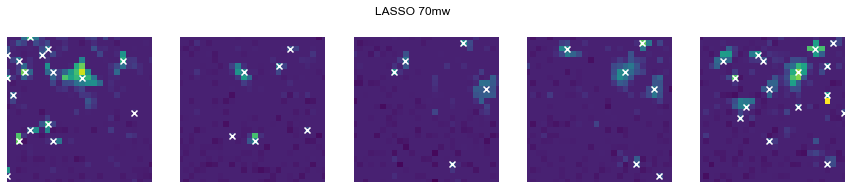

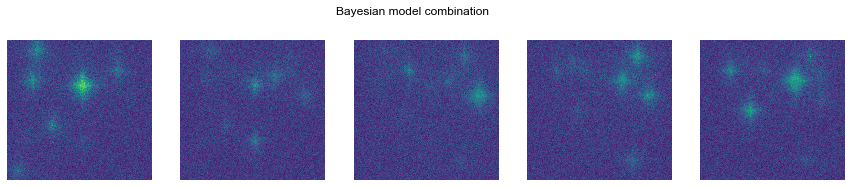

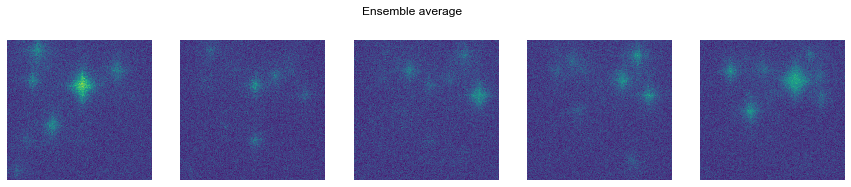

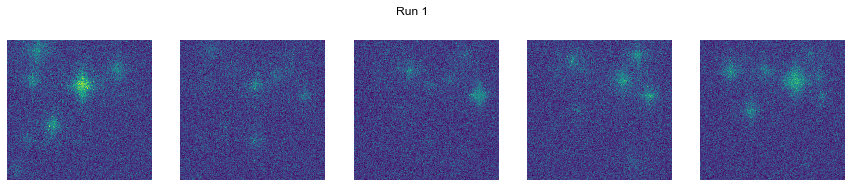

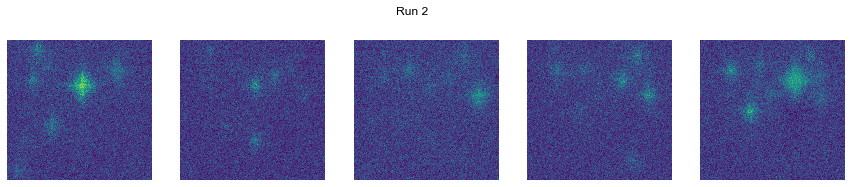

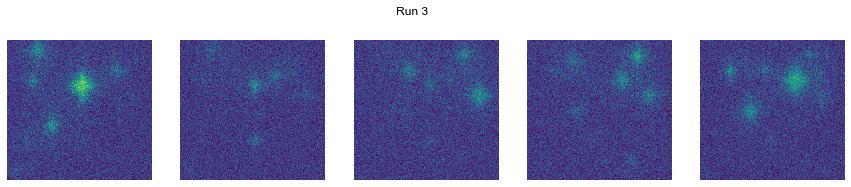

In [94]:
# Lasso maps
plt.figure(figsize=(fcoef*ndepths, fcoef))
plt.suptitle('LASSO 70mw')
for i, d in enumerate(depths):
    curr_plane = np.where(targets[:, -1] == d)[0]
    cell_loc_on_plane = []
    for j in range(len(cell_locs)):
        tmp = np.where(cell_locs_as_targets[j] == curr_plane)[0]
        if len(tmp) > 0:
            cell_loc_on_plane += [tmp]
            lasso_init[j] = lmap_70[curr_plane][tmp]
    cell_loc_on_plane = np.array(cell_loc_on_plane)
    coords = np.array([np.where(dummy_arr == cell_loc_on_plane[i]) for i in range(len(cell_loc_on_plane))]).squeeze()
    
    plt.subplot(1, ndepths, i + 1)
    plt.imshow(lmap_70[curr_plane].reshape([dim, dim]), cmap='viridis_r', vmin=vmin, vmax=vmax)
    plt.scatter(coords[:, 1], coords[:, 0], marker='x', color='white')
    plt.xlim([0, dim-1])
    plt.ylim([dim-1, 0])
    plt.axis('off')
# plt.savefig('figs/experimental_data/posterior_predictive_mean_lasso_70mw.png', format='png', dpi=200, bbox_inches='tight')
plt.show()

plt.figure(figsize=(fcoef*ndepths, fcoef))
plt.suptitle('Bayesian model combination')
for i, d in enumerate(depths):
    curr_plane = np.where(model.cell_locs[:, -1] == d)[0]
    coords = model.cell_locs[curr_plane]
    plt.subplot(1, ndepths, i + 1)
    plt.imshow(pred_map_70_bayes[str(d)].reshape(len(yr), len(xr)).T, cmap='viridis_r', vmin=vmin, vmax=vmax)
    plt.axis('off')

# plt.savefig('figs/experimental_data/posterior_predictive_mean_bayes_ensemble_70mw.png', format='png', dpi=200, bbox_inches='tight')
plt.show()

plt.figure(figsize=(fcoef*ndepths, fcoef))
plt.suptitle('Ensemble average')
for i, d in enumerate(depths):
    plt.subplot(1, ndepths, i + 1)
    plt.imshow(np.mean(pred_maps_70[str(d)], 0).reshape(len(yr), len(xr)).T, cmap='viridis_r', vmin=vmin, vmax=vmax)
    plt.axis('off')
plt.show()

for e in range(ensemble_size):
    plt.figure(figsize=(fcoef*ndepths, fcoef))
    plt.suptitle('Run %i'%(e+1))
    for i, d in enumerate(depths):
        plt.subplot(1, ndepths, i + 1)
        plt.imshow(pred_maps_70[str(d)][e].reshape(len(yr), len(xr)).T, cmap='viridis_r', vmin=vmin, vmax=vmax)
        plt.axis('off')
    plt.show()

In [95]:
y_train.shape

(50700,)

ValueError: x and y must be the same size

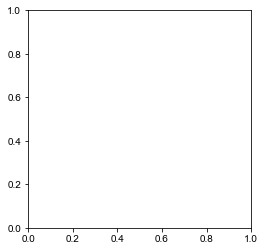

In [86]:
w_est = mu * alpha
for i in range(ensemble_size):
    lam = np.array(models[i].state['lam']).T
    y_est = w_est @ lam
    plt.figure(figsize=(4, 4))
    plt.scatter(y_train, y_est)
    plt.axis('equal')
    plt.plot([-12, 2], [-12, 2], '--', color='gray')
    plt.show()
    print(np.corrcoef(y_train, y_est)[0, 1])

# Cross validation

In [ ]:
"""N-fold cross-validation
"""

def get_subsample_indices(targets, nfolds=5, test_frac=0.1):
    ntars = len(targets)
    arr = np.arange(ntars)
    hold_out_frac = 1/nfolds
    train_inds = []
    test_inds = []
    for n in range(nfolds):
        train_inds += [np.random.choice(arr, int(ntars * (1 - test_frac)), replace=False)]
        test_inds += [np.setdiff1d(arr, train_inds)]
    return train_inds, test_inds

def get_subsample_trials(L, train_tar_inds):
    train_tars = targets[train_tar_inds]
    train_loc_inds = []
    for i, t in enumerate(train_tars):
        train_loc_inds += [find_common([np.where(L[:, i] == t[i]) for i in range(L.shape[1])])]
    train_loc_inds = np.array(train_loc_inds).flatten()
    test_loc_inds = np.setdiff1d(np.arange(L.shape[0]), train_loc_inds)
    return train_loc_inds, test_loc_inds


In [ ]:
train_inds, test_inds = get_subsample_indices(targets, nfolds=1, test_frac=0.2)
train_loc_inds, test_loc_inds = get_subsample_trials(L, train_inds[0])
n_training_trials = len(train_loc_inds)

In [ ]:
print(train_loc_inds.shape)
print(test_loc_inds.shape)

In [ ]:
interp = 0.1
N = len(cell_locs)
priors = {
    'alpha': 0.5 * np.ones(N),
    'Omega': np.array([np.diag([0.00389425, 0.00391111, 0.00074478]) for _ in range(N)]),
    'mu': np.zeros(N),
#     'mu': lasso_init,
    'beta': 2 * np.ones(N),
    'shape': 1,
    'rate': 1,
    'phi_map': np.c_[0.03203156 * np.ones(N), 5.216092 * np.ones(N)],
    'phi_cov': np.array([np.array([[1e-2, 0], [0, 1e0]]) for _ in range(N)])
}

fit_options = {
    'iters': 10,
    'newton_steps': 15, # default 10
    'lam_update': 'monte-carlo',
    'num_mc_samples': 10, # default 5
    'verbose': False,
    'init_t': 1e1,
    't_loops': 3, # default 3
    't_mult': 15,
    'interp': interp
}

ensemble_size = 5
models = [adaprobe.Model(cell_locs, priors=priors, variational_model='omega-3d') for _ in range(ensemble_size)]

In [ ]:
hist = init_hist_dict(ensemble_size, descriptors=descriptors)

nruns = 1

for e in range(ensemble_size):
    for run in range(nruns):
        t1 = time.time()
        for j in range(n_training_trials):
            k = train_loc_inds[j]
            print('trial %i/%i'%(j + 1, n_training_trials), end='\r')
            models[e].update(y[k], (L[k], I[k]), fit_options=fit_options, method='cavi_online_spike_and_slab_3d_omega')
            record_hist(hist[e], models[e], descriptors=descriptors)

        t2 = time.time()
        print('elapsed time %.2f'%(t2 - t1))

In [ ]:
ev = np.array([model_evidence_omega_3d(y, model, I, L, num_mc_samples=10) for model in models])
posterior_weights = ev/np.sum(ev)

In [ ]:
xrange = np.arange(-10, 5, 0.1)
def gaussf(mean, sdev):
    return 1/(np.sqrt(2 * np.pi * sdev**2)) * np.exp(-1/(2 * sdev**2) * (xrange - mean)**2)

alpha = np.sum([models[i].state['alpha'] * posterior_weights[i] for i in range(len(posterior_weights))], 0)
mu = np.sum([models[i].state['mu'] * posterior_weights[i] for i in range(len(posterior_weights))], 0)
beta = np.sum([models[i].state['beta'] * posterior_weights[i] for i in range(len(posterior_weights))], 0)
lam = np.sum([np.array(models[i].state['lam']).T * posterior_weights[i] for i in range(len(posterior_weights))], 0)
posteriors = np.array([alpha[n] * gaussf(mu[n], beta[n]) for n in range(N)])

ymax = np.max(np.array([gaussf(models[i].state['mu'][n], models[i].state['beta'][n]) for i in range(ensemble_size) for n in range(N)]))

plt.figure(figsize=(12, 2*(N/4)))
for n in range(N):
    plt.subplot(int(np.ceil(N/4)), 4, n + 1)
    
    # Plot posteriors
    for i in range(ensemble_size):
        postn = models[i].state['alpha'][n] * gaussf(models[i].state['mu'][n], models[i].state['beta'][n])
        plt.plot(xrange, postn, color='gray', alpha=0.5)
    plt.plot(xrange, posteriors[n], color='firebrick', linewidth=2)
    
    plt.ylim([-0.05, ymax + 0.05])
    plt.xlim(np.min(xrange), np.max(xrange))
    if n == 0: 
        plt.ylabel('Slab density', fontsize=fontsize)
plt.show()

In [ ]:
## Ensemble code

# Plot synapse means

plt.figure(figsize=(ensemble_size*6, 2.5))
for i in range(ensemble_size):
    plt.subplot(1, ensemble_size, i + 1)
    plt.plot(np.array(hist[i]['mu']))
    plt.title('Run %i'%(i+1), fontsize=fontsize)
    for loc in ['top', 'right']:
        plt.gca().spines[loc].set_visible(False)
    if i == 0:
        plt.ylabel('Synapse posterior mean', fontsize=fontsize)
        plt.xlabel('Trial (x10,000)', fontsize=fontsize)
    else:
        plt.yticks([])
plt.show()

In [ ]:
## Ensemble code

plt.figure(figsize=(ensemble_size*6, 2.5))
for i in range(ensemble_size):
    plt.subplot(1, ensemble_size, i + 1)
    plt.plot(np.array(hist[i]['alpha']))
    plt.title('Run %i'%(i+1), fontsize=fontsize)
    for loc in ['top', 'right']:
        plt.gca().spines[loc].set_visible(False)
    if i == 0:
        plt.ylabel('Synapse connection prob', fontsize=fontsize)
        plt.xlabel('Trial (x10,000)', fontsize=fontsize)
    else:
        plt.yticks([])
plt.show()

In [ ]:
# lam = np.array(model.state['lam']).T
# mu = model.state['mu']
y_train_est = mu @ lam

plt.figure(figsize=(4, 4))
plt.scatter(y[train_loc_inds], y_train_est)
plt.axis('equal')
plt.show()

np.corrcoef(y[train_loc_inds], y_train_est)

In [ ]:
posterior_weights

In [ ]:
np.sum([models[e].state['phi_cov'] * posterior_weights[e] for i in range(ensemble_size)], 0).shape

In [ ]:
def estimate_resp_avg_spikes(model, L, I, num_mc_samples=10):
    K = len(I)
    N = len(model.cell_locs)
    m = np.zeros((N, K))
    for n in range(N):
        for k in range(K):
            m[n, k] = I[k] * np.exp(-(L[k] - model.cell_locs[n]) @ model.state['Omega'][n] @ (L[k] - model.cell_locs[n]))
    y_est = np.zeros(K)
    for i in range(num_mc_samples):
        phi = np.array([_sample_phi_independent_truncated_normals(
            model.state['phi_map'][n], model.state['phi_cov'][n], num_mc_samples=1
        ) for n in range(N)]).squeeze()
        f = sigmoid(np.array([phi[n, 0] * m[n] - phi[n, 1] for n in range(N)]))
        s = np.random.rand(N, K) <= f
        y_est += model.state['alpha'] * model.state['mu'] @ s
    return y_est/num_mc_samples

def estimate_resp_avg_spikes_ensemble(models, weights, L, I, num_mc_samples=10):
    model = models[0]
    K = len(I)
    N = len(model.cell_locs)
    m = np.zeros((N, K))
    for n in range(N):
        for k in range(K):
            m[n, k] = I[k] * np.exp(-(L[k] - model.cell_locs[n]) @ model.state['Omega'][n] @ (L[k] - model.cell_locs[n]))
    y_est = np.zeros(K)
    phi_map = np.sum([models[e].state['phi_map'] * posterior_weights[e] for i in range(ensemble_size)], 0)
    phi_cov = np.sum([models[e].state['phi_cov'] * posterior_weights[e] for i in range(ensemble_size)], 0)
    alpha = np.sum([models[e].state['alpha'] * posterior_weights[e] for e in range(len(posterior_weights))], 0)
    mu = np.sum([models[e].state['mu'] * posterior_weights[e] for e in range(ensemble_size)], 0)
    
    for i in range(num_mc_samples):
        phi = np.array([_sample_phi_independent_truncated_normals(
            phi_map[n], phi_cov[n], num_mc_samples=1
        ) for n in range(N)]).squeeze()
        f = sigmoid(np.array([phi[n, 0] * m[n] - phi[n, 1] for n in range(N)]))
        s = np.random.rand(N, K) <= f
        y_est += alpha * mu @ s
    return y_est/num_mc_samples

In [ ]:
# y_est = estimate_resp_avg_spikes(model, L[test_loc_inds], I[test_loc_inds], num_mc_samples=100)
y_est = estimate_resp_avg_spikes_ensemble(models, posterior_weights, L[test_loc_inds], I[test_loc_inds], num_mc_samples=100)

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y[test_loc_inds], y_est)
plt.xlim([-8, 2])
plt.ylim([-8, 2])
plt.show()

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y[test_loc_inds], y_est)
plt.xlim([-3, 1])
plt.ylim([-3, 1])
plt.show()

In [ ]:
np.corrcoef(y[test_loc_inds], y_est)

In [ ]:
bayes_maps = [adaprobe.experimental_design.posterior_predictive_map_on_plane_bayes_ensemble_3d_omega(grid, y, plane=d, power=70, I_hist=I, L_hist=L, models=models, n_samples=30) for d in depths]

In [ ]:
for i, d in enumerate(depths):
    plt.figure(figsize=(8, 4))
    curr_plane = np.where(targets[:, -1] == d)[0]
    cell_loc_on_plane = []
    for j in range(len(cell_locs)):
        tmp = np.where(cell_locs_as_targets[j] == curr_plane)[0]
        if len(tmp) > 0:
            cell_loc_on_plane += [tmp]
            lasso_init[j] = lmap_70[curr_plane][tmp]
    cell_loc_on_plane = np.array(cell_loc_on_plane)
    coords = np.array([np.where(dummy_arr == cell_loc_on_plane[i]) for i in range(len(cell_loc_on_plane))]).squeeze()

    vmin = np.min(lmap_70[curr_plane])
    vmax = np.max(lmap_70[curr_plane])
    
    plt.subplot(1, 2, 1)
    plt.imshow(lmap_70[curr_plane].reshape([dim, dim]).T, cmap='viridis_r', vmin=vmin, vmax=vmax)
    plt.scatter(coords[:, 0], coords[:, 1], marker='x', color='white')
    plt.xlim([0, dim-1])
    plt.ylim([dim-1, 0])

    plt.subplot(1, 2, 2)
    plt.imshow(bayes_maps[i].reshape(len(yr), len(xr)), cmap='viridis_r', vmin=vmin, vmax=vmax)

    plt.show()

# Cross validation using proximal trials

In [ ]:
N = len(cell_locs)

In [ ]:
def locs_within_radius(loc, rad, targets):
    return np.where(np.sqrt(np.sum([(loc[i] - targets[:, i])**2 for i in range(3)], 0)) < rad)[0]

def get_locs_near_cells(cell_locs, targets, rad=20):
    return np.unique(np.concatenate([locs_within_radius(cell_locs[i], rad, targets) for i in range(N)]))

In [ ]:
close_tars = targets[get_locs_near_cells(cell_locs, targets, rad=30)]

In [ ]:
close_trial_inds = np.array([])
for j in range(close_tars.shape[0]):
    close_trial_inds = np.concatenate([close_trial_inds, find_common([np.where(L[:, i] == close_tars[j][i]) for i in range(3)])])
close_trial_inds = close_trial_inds.astype(int)

In [ ]:
n_close_trials = len(close_trial_inds)

In [ ]:
L[close_trial_inds]

In [ ]:
_close_trial_inds_train = np.random.choice(n_close_trials, int(0.9 * n_close_trials), replace=False)
close_trial_inds_train = close_trial_inds[_close_trial_inds_train]
close_trial_inds_test = close_trial_inds[np.setdiff1d(np.arange(n_close_trials), _close_trial_inds_train)]

In [ ]:
interp = 0.075
N = len(cell_locs)
priors = {
    'alpha': 0.5 * np.ones(N),
    'Omega': np.array([np.diag([0.00389425, 0.00391111, 0.00074478]) for _ in range(N)]),
    'mu': np.zeros(N),
    'beta': 2 * np.ones(N),
    'shape': 1,
    'rate': 1,
    'phi_map': np.c_[0.03203156 * np.ones(N), 5.216092 * np.ones(N)],
    'phi_cov': np.array([np.array([[1e-2, 0], [0, 1e0]]) for _ in range(N)])
}

fit_options = {
    'iters': 10,
    'newton_steps': 15, # default 10
    'lam_update': 'monte-carlo',
    'num_mc_samples': 10, # default 5
    'verbose': False,
    'init_t': 1e1,
    't_loops': 3, # default 3
    't_mult': 15,
    'interp': interp
}

ensemble_size = 3
models = [adaprobe.Model(cell_locs, priors=priors, variational_model='omega-3d') for _ in range(ensemble_size)]

In [ ]:
hist = init_hist_dict(ensemble_size, descriptors=descriptors)

for e in range(ensemble_size):
    t1 = time.time()
    for j in range(len(close_trial_inds_train)):
        k = close_trial_inds_train[j]
        print('trial %i/%i'%(j + 1, len(close_trial_inds_train)), end='\r')
        models[e].update(y[k], (L[k], I[k]), fit_options=fit_options, method='cavi_online_spike_and_slab_3d_omega')
        record_hist(hist[e], models[e], descriptors=descriptors)

    t2 = time.time()
    print('elapsed time %.2f'%(t2 - t1))

In [ ]:
ev = np.array([model_evidence_omega_3d(y, model, I, L, num_mc_samples=10) for model in models])
posterior_weights = ev/np.sum(ev)

In [ ]:
xrange = np.arange(-10, 5, 0.1)
def gaussf(mean, sdev):
    return 1/(np.sqrt(2 * np.pi * sdev**2)) * np.exp(-1/(2 * sdev**2) * (xrange - mean)**2)

alpha = np.sum([models[i].state['alpha'] * posterior_weights[i] for i in range(len(posterior_weights))], 0)
mu = np.sum([models[i].state['mu'] * posterior_weights[i] for i in range(len(posterior_weights))], 0)
beta = np.sum([models[i].state['beta'] * posterior_weights[i] for i in range(len(posterior_weights))], 0)
lam = np.sum([np.array(models[i].state['lam']).T * posterior_weights[i] for i in range(len(posterior_weights))], 0)
posteriors = np.array([alpha[n] * gaussf(mu[n], beta[n]) for n in range(N)])

ymax = np.max(np.array([gaussf(models[i].state['mu'][n], models[i].state['beta'][n]) for i in range(ensemble_size) for n in range(N)]))

plt.figure(figsize=(12, 2*(N/4)))
for n in range(N):
    plt.subplot(int(np.ceil(N/4)), 4, n + 1)
    
    # Plot posteriors
    for i in range(ensemble_size):
        postn = models[i].state['alpha'][n] * gaussf(models[i].state['mu'][n], models[i].state['beta'][n])
        plt.plot(xrange, postn, color='gray', alpha=0.5)
    plt.plot(xrange, posteriors[n], color='firebrick', linewidth=2)
    
    plt.ylim([-0.05, ymax + 0.05])
    plt.xlim(np.min(xrange), np.max(xrange))
    if n == 0: 
        plt.ylabel('Slab density', fontsize=fontsize)
plt.show()

In [ ]:
## Ensemble code

# Plot synapse means

plt.figure(figsize=(ensemble_size*6, 2.5))
for i in range(ensemble_size):
    plt.subplot(1, ensemble_size, i + 1)
    plt.plot(np.array(hist[i]['mu']))
    plt.title('Run %i'%(i+1), fontsize=fontsize)
    for loc in ['top', 'right']:
        plt.gca().spines[loc].set_visible(False)
    if i == 0:
        plt.ylabel('Synapse posterior mean', fontsize=fontsize)
        plt.xlabel('Trial (x10,000)', fontsize=fontsize)
    else:
        plt.yticks([])
plt.show()

In [ ]:
## Ensemble code

plt.figure(figsize=(ensemble_size*6, 2.5))
for i in range(ensemble_size):
    plt.subplot(1, ensemble_size, i + 1)
    plt.plot(np.array(hist[i]['alpha']))
    plt.title('Run %i'%(i+1), fontsize=fontsize)
    for loc in ['top', 'right']:
        plt.gca().spines[loc].set_visible(False)
    if i == 0:
        plt.ylabel('Synapse connection prob', fontsize=fontsize)
        plt.xlabel('Trial (x10,000)', fontsize=fontsize)
    else:
        plt.yticks([])
plt.show()

In [ ]:
y_train_est = mu @ lam

plt.figure(figsize=(4, 4))
plt.scatter(y[close_trial_inds_train], y_train_est)
plt.plot([-10, 1], [-10, 1], '--', color='gray')
plt.show()

np.corrcoef(y[close_trial_inds_train], y_train_est)

In [ ]:
y_test_est = estimate_resp_avg_spikes_ensemble(models, posterior_weights, L[close_trial_inds_test], I[close_trial_inds_test], num_mc_samples=100)

In [ ]:
plt.figure(figsize=(4, 4))
plt.scatter(y[close_trial_inds_test], y_test_est)
plt.xlim([-9, 2])
plt.ylim([-9, 2])
plt.show()

In [ ]:
np.corrcoef(y_test_est, y[close_trial_inds_test])

In [ ]:
bayes_maps = [adaprobe.experimental_design.posterior_predictive_map_on_plane_bayes_ensemble_3d_omega(grid, y, plane=d, power=70, I_hist=I, L_hist=L, models=models, n_samples=20) for d in depths]

In [ ]:
plt.figure(figsize=(16, 6))
plt_cntr = 1
for i, d in enumerate(depths):
    curr_plane = np.where(targets[:, -1] == d)[0]
    cell_loc_on_plane = []
    for j in range(len(cell_locs)):
        tmp = np.where(cell_locs_as_targets[j] == curr_plane)[0]
        if len(tmp) > 0:
            cell_loc_on_plane += [tmp]
            lasso_init[j] = lmap_70[curr_plane][tmp]
    cell_loc_on_plane = np.array(cell_loc_on_plane)
    coords = np.array([np.where(dummy_arr == cell_loc_on_plane[i]) for i in range(len(cell_loc_on_plane))]).squeeze()

    vmin = np.min(lmap_70[curr_plane])
    vmax = np.max(lmap_70[curr_plane])
    
    plt.subplot(2, ndepths, plt_cntr)
    if i == 0:
        plt.ylabel('Blind LASSO', fontsize=fontsize)
    plt.imshow(lmap_70[curr_plane].reshape([dim, dim]).T, cmap='viridis_r', vmin=vmin, vmax=vmax)
    plt.scatter(coords[:, 0], coords[:, 1], marker='x', color='white')
    plt.xlim([0, dim-1])
    plt.ylim([dim-1, 0])
    plt_cntr += 1
    
for i, d in enumerate(depths):
    curr_plane = np.where(targets[:, -1] == d)[0]
    vmin = np.min(lmap_70[curr_plane])
    vmax = np.max(lmap_70[curr_plane])
    
    plt.subplot(2, ndepths, plt_cntr)
    if i == 0:
        plt.ylabel('Statistical model', fontsize=fontsize)
    plt.imshow(bayes_maps[i].reshape(len(yr), len(xr)), cmap='viridis_r', vmin=vmin, vmax=vmax)
    plt_cntr += 1

# plt.savefig('figs/loose_patch/blind_map_vs_model_3d_omega.png', format='png', bbox_inches='tight', dpi=200)
plt.show()